In [1]:
#Importing the necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
#libraries for scalling the data
import sklearn
from sklearn.preprocessing import StandardScaler
#Import cluster modules
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#Importing libraries for hierarchical clustering 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram 
from scipy.cluster.hierarchy import cut_tree

## STEP 1: Reading and understanding the data

In [2]:
#Loading the dataset
df = pd.read_csv('Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
#Converting exports,imports and health spending percentages to absolute values.
df['exports'] = df['exports']*df['gdpp']/100
df['imports'] = df['imports']*df['gdpp']/100
df['health'] = df['health']*df['gdpp']/100

In [4]:
#All the data types are as they should be
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [5]:
df.shape

(167, 10)

In [6]:
#The data does not contain any missing values
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## STEP 2: Data Visualization

### The data seems fairly clean and does not contain any missing values. We can start to visualize the data to understand it a little better.

In [7]:
#Need to plot all the continuous vaiables in order to find the correlation between them
df_copy=df
df_remove_outliers=df.drop(['country'],axis=1)
df_cont=df.drop(['country'],axis=1)

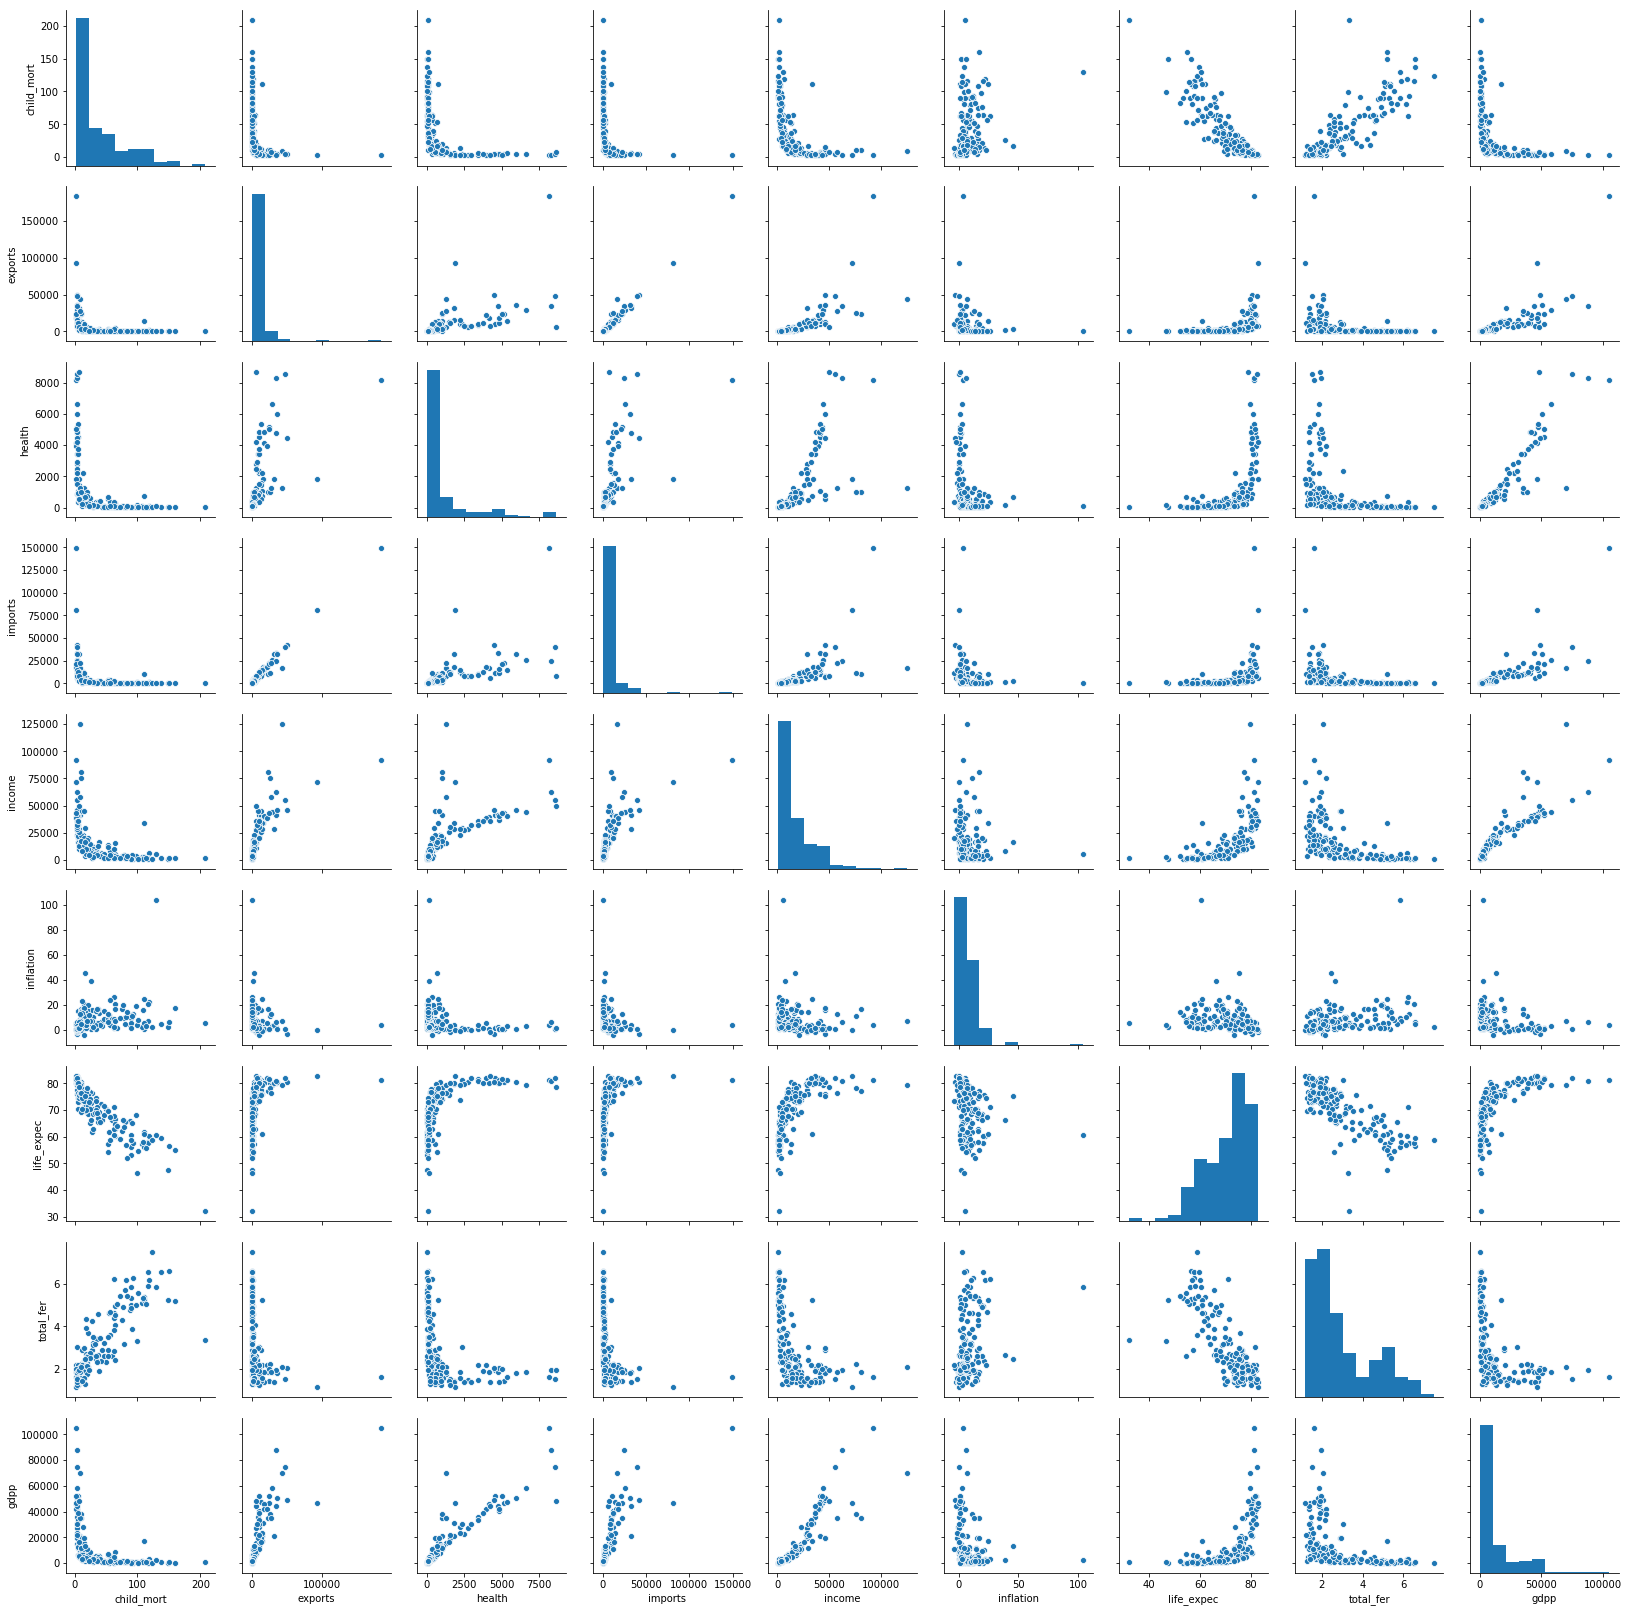

In [8]:
sns.pairplot(data=df,vars=df_cont)
plt.show()

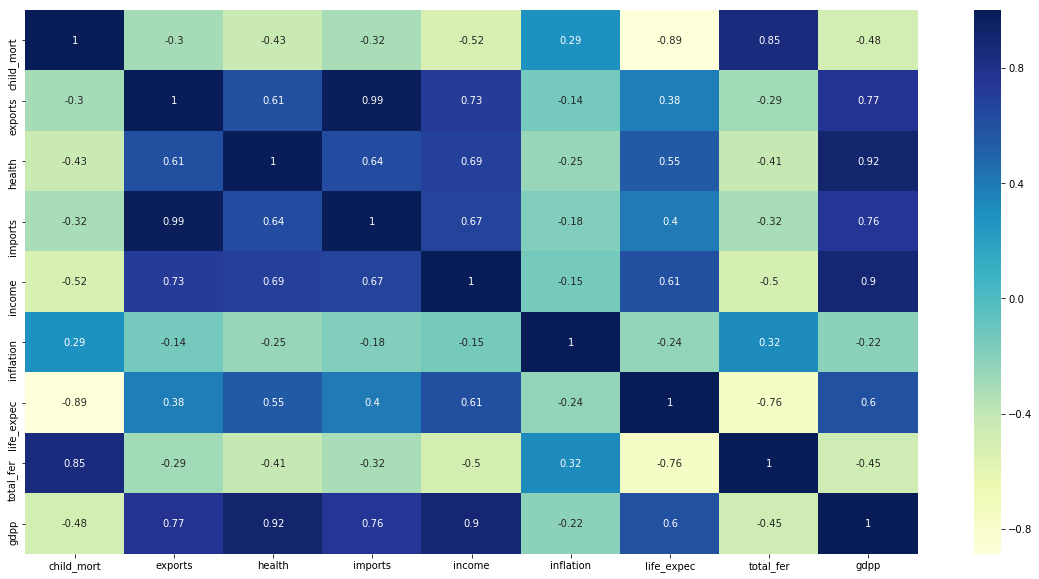

In [9]:
plt.figure(figsize = (20,10))        
sns.heatmap(df_cont.corr(),annot = True,cmap='YlGnBu')
plt.show()

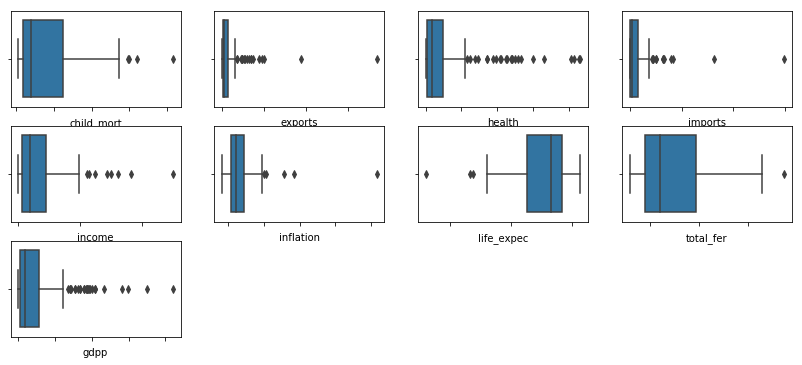

In [10]:
#Plotting all the continuous variables to check for outliers
i=1
plt.figure(figsize=[14,6])
features=['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for feature in features:
    plt.subplot(3,4,i)
    s=sns.boxplot(x=feature,data=df)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    i=i+1
plt.show()

### Printing out the outliers above and below the lower and upper fence respectively keeping the Q1 and Q3 0.05 and 0.95 repectively inorder to print only the most extreme values.

In [11]:
#Checking all the continuous variables for outliers
Q1=df.exports.quantile(0.05)
Q3=df.exports.quantile(0.95)
IQR=Q3-Q1
print('exports')
print('Greater than Upper Fence')
print(df[df.exports>Q3+(1.5*IQR)])
print()
print('Smaller than Lower Fence')
print(df[df.exports<Q1-(1.5*IQR)])
print()
print()
Q1=df.imports.quantile(0.05)
Q3=df.imports.quantile(0.95)
IQR=Q3-Q1
print('imports')
print('Greater than Upper Fence')
print(df[df.imports>Q3+(1.5*IQR)])
print()
print('Smaller than Lower Fence')
print(df[df.imports<Q1-(1.5*IQR)])
print()
print()
Q1=df.income.quantile(0.05)
Q3=df.income.quantile(0.95)
IQR=Q3-Q1
print('income')
print('Greater than Upper Fence')
print(df[df.income>Q3+(1.5*IQR)])
print()
print('Smaller than Lower Fence')
print(df[df.income<Q1-(1.5*IQR)])
print()
print()
Q1=df.inflation.quantile(0.05)
Q3=df.inflation.quantile(0.95)
IQR=Q3-Q1
print('inflation')
print('Greater than Upper Fence')
print(df[df.inflation>Q3+(1.5*IQR)])
print()
print('Smaller than Lower Fence')
print(df[df.inflation<Q1-(1.5*IQR)])

exports
Greater than Upper Fence
        country  child_mort   exports   health   imports  income  inflation  \
91   Luxembourg         2.8  183750.0  8158.50  149100.0   91700      3.620   
133   Singapore         2.8   93200.0  1845.36   81084.0   72100     -0.046   

     life_expec  total_fer    gdpp  
91         81.3       1.63  105000  
133        82.7       1.15   46600  

Smaller than Lower Fence
Empty DataFrame
Columns: [country, child_mort, exports, health, imports, income, inflation, life_expec, total_fer, gdpp]
Index: []


imports
Greater than Upper Fence
        country  child_mort   exports   health   imports  income  inflation  \
91   Luxembourg         2.8  183750.0  8158.50  149100.0   91700      3.620   
133   Singapore         2.8   93200.0  1845.36   81084.0   72100     -0.046   

     life_expec  total_fer    gdpp  
91         81.3       1.63  105000  
133        82.7       1.15   46600  

Smaller than Lower Fence
Empty DataFrame
Columns: [country, child_mort, expo

### From the statitical perspective the points above the upper fence are outliers but looking it from the domain we realise that removing that information may not be a good idea as we will be losing some important information.

### Lets make another dataset for outlier elimination

In [12]:
#removing statistical outliers
#Treatement for exports 
Q1=df_remove_outliers.exports.quantile(0.05)
Q3=df_remove_outliers.exports.quantile(0.95)
IQR=Q3-Q1
df_remove_outliers=df_remove_outliers[(df_remove_outliers.exports>Q1-(1.5*IQR))&(df_remove_outliers.exports<=Q3+(1.5*IQR))]

#Treatement for imports  
Q1=df_remove_outliers.imports.quantile(0.05)
Q3=df_remove_outliers.imports.quantile(0.95)
IQR=Q3-Q1
df_remove_outliers=df_remove_outliers[(df_remove_outliers.imports>Q1-(1.5*IQR))&(df_remove_outliers.imports<=Q3+(1.5*IQR))]

#Treatement for income
Q1=df_remove_outliers.income.quantile(0.05)
Q3=df_remove_outliers.income.quantile(0.95)
IQR=Q3-Q1
df_remove_outliers=df_remove_outliers[(df_remove_outliers.income>Q1-(1.5*IQR))&(df_remove_outliers.income<=Q3+(1.5*IQR))]

#Treatement for inflation
Q1=df_remove_outliers.inflation.quantile(0.05)
Q3=df_remove_outliers.inflation.quantile(0.95)
IQR=Q3-Q1
df_remove_outliers=df_remove_outliers[(df_remove_outliers.inflation>Q1-(1.5*IQR))&(df_remove_outliers.inflation<=Q3+(1.5*IQR))]

## STEP 3: Data Preparation

### We have decided not to remove outliers but it is still worthwhile to see the hopkins statistic to see if the data is fit for clustering. We will be computing this value for both outlier treated and outlier not treated datasets.

In [13]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [14]:
#Let's check the Hopkins measure for outlier non treated data
hopkins(df_cont)

0.9597440409472021

In [15]:
#Let's check the Hopkins measure for outlier treated data
hopkins(df_remove_outliers)

0.9360293071610728

In [16]:
#Standardizing the data and storing it in a different dataframe
Scaler=StandardScaler()
df_scaler=Scaler.fit_transform(df_cont)

In [17]:
df_scaler=pd.DataFrame(df_scaler)
df_scaler.columns=df_cont.columns
df_scaler.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.411011,-0.565040,-0.432276,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.350191,-0.439218,-0.313677,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.318526,-0.484826,-0.353720,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,-0.291375,-0.532363,-0.345953,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,-0.104331,-0.178771,0.040735,0.101732,-0.601749,0.704258,-0.541946,-0.041817


# STEP 4: Clustering

### K means Clustering

### Trying to find the optimal number of clusters using the Elbow method

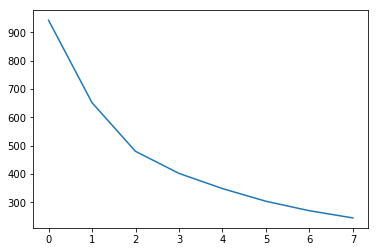

In [18]:
#Finding the optimal number of clusters
#Defining different number of clusters n_range_cluesters = [2,3,4,5,6,7,8,9]
#We use a for loop to iterate a form a kmeans obejct and fit that our df with that object.
n_range_clusters=[2,3,4,5,6,7,8,9]
ssd=[]
for num_clusters in n_range_clusters:
    kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(df_scaler)
    ssd.append(kmeans.inertia_)
plt.plot(ssd)
plt.show()

### It is found that the a distinct elbow is formed between clusters 3 to 6

### Silhouette analysis

### Using the same technique as earlier we loop through different silhouette scores based on the different cluster labels which are in turn created using different number of clusters.

In [19]:
#Using the Silhouette analysis
n_range_cluster=[2,3,4,5,6,7,8,9]
for num_clusters in n_range_clusters:
    kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(df_scaler)
    cluster_labels=kmeans.labels_
    avg_score=silhouette_score(df_scaler,cluster_labels)
    print("n_clusters{0}, silhouette_score{1}".format(num_clusters,avg_score))

n_clusters2, silhouette_score0.45863306035476264
n_clusters3, silhouette_score0.4218615812599681
n_clusters4, silhouette_score0.4277518271600435
n_clusters5, silhouette_score0.4324001169216119
n_clusters6, silhouette_score0.31484843378326144
n_clusters7, silhouette_score0.31136565295133073
n_clusters8, silhouette_score0.2898748482306358
n_clusters9, silhouette_score0.295715162395454


### We have choosen to go with the number of clusters as 3 due to the distinct curve formation in the elobow curve between values 3 to 6 in the elbow method. Even though the Silhouette score of 4 is slightly higher than 3 we would like to go with Total number of clusters as 3.  Choosing 4 clusters might segregate the poor countries into 2 different clusters.

In [20]:
#Building and fitting the model with 3 clusters
kmeans=KMeans(n_clusters=3,max_iter=50)
kmeans.fit(df_scaler)

KMeans(max_iter=50, n_clusters=3)

In [21]:
#Storing the cluster numbers as cluster_id
df_copy['cluster_id']=kmeans.labels_
df_cont['cluster_id']=kmeans.labels_

In [22]:
kmeans.labels_

array([1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1,
       0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0,
       2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       2, 2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1])

In [23]:
df_copy.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


### Ploting the boxplots of the 3 important columns 'child_mort', 'income' and 'gdpp' in order to visualise if they do or do not have a wide range due to outliers.

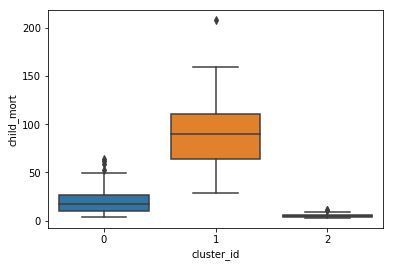

In [24]:
sns.boxplot(x='cluster_id',y='child_mort',data=df_cont)
plt.show()

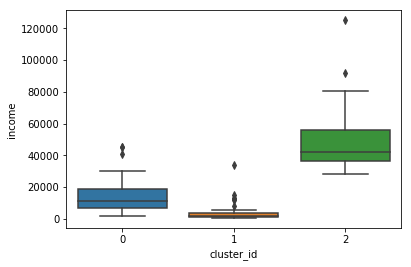

In [25]:
sns.boxplot(x='cluster_id',y='income',data=df_cont)
plt.show()

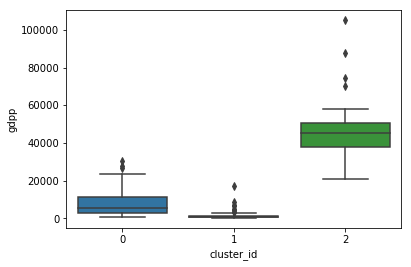

In [26]:
sns.boxplot(x='cluster_id',y='gdpp',data=df_cont)
plt.show()

### Very few extreme values exist but raises no red flags as the ranges are fairly low.

### Plotting the scatter plot with the hue set as the cluster_id' for 'child_mort', 'income' and 'gdpp'  the variables to help us visualise the different cluster formations.

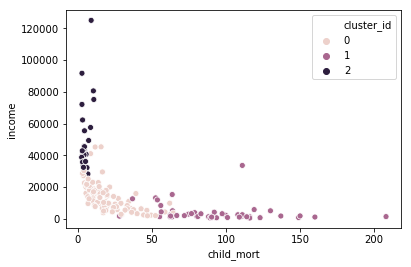

In [27]:
sns.scatterplot(x='child_mort',y='income',hue='cluster_id',data=df_cont)
plt.show()

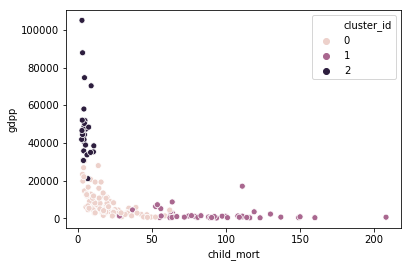

In [28]:
sns.scatterplot(x='child_mort',y='gdpp',hue='cluster_id',data=df_cont)
plt.show()

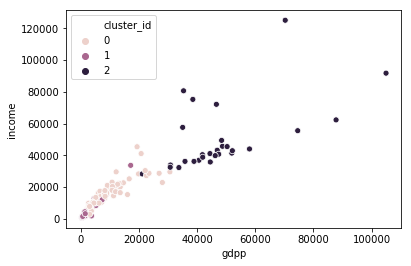

In [29]:
sns.scatterplot(x='gdpp',y='income',hue='cluster_id',data=df_cont)
plt.show()

### We deduce that the extreme values that exist are for countries with high gpp and income and low child mortality. Since this is not  our focus we do not require to alter the data.

### From the above plot we are able to see that K means clustering in quite accurate as it has accurately placed the low performing countries together in one cluster and furthur one going to mediocure and then finally high performing countries.

### Heirarchical Clustering

### Single Linkage

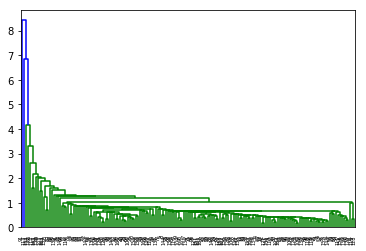

In [30]:
mergings=linkage(df_scaler,method='single',metric='euclidean')
dendrogram(mergings)
plt.show()

### Average Linkage

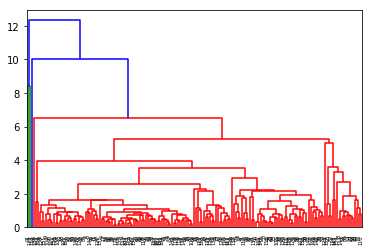

In [31]:
mergings=linkage(df_scaler,method='average',metric='euclidean')
dendrogram(mergings)
plt.show()

### Complete Linkage

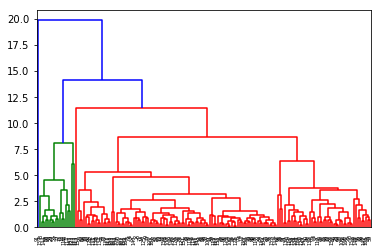

In [32]:
mergings=linkage(df_scaler,method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

### Choosing 3 clusters

In [33]:
cluster_labels=cut_tree(mergings,n_clusters=3).reshape(-1,)
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

### Saving the clusters labelsformed by heirarchical clustering to the main dataframe

In [34]:
df['cluster_labels']=cluster_labels
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,1,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,1,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0,0


### Printing cluster wise to view the which countries fall into which cluster. This is also done so that we can make sure the there is a trend in the 'gdpp' , 'income' and 'child_mort', meaning that low performing countries fall into same clusters and further on like that.

In [35]:
df_copy[df_copy['cluster_labels']==0]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610,9.440,56.2,5.82,553,1,0
1,Albania,16.6,1145.2000,267.8950,1987.740,9930,4.490,76.3,1.65,4090,0,0
2,Algeria,27.3,1712.6400,185.9820,1400.440,12900,16.100,76.5,2.89,4460,0,0
3,Angola,119.0,2199.1900,100.6050,1514.370,5900,22.400,60.1,6.16,3530,1,0
4,Antigua and Barbuda,10.3,5551.0000,735.6600,7185.800,19100,1.440,76.8,2.13,12200,0,0
5,Argentina,14.5,1946.7000,834.3000,1648.000,18700,20.900,75.8,2.37,10300,0,0
6,Armenia,18.1,669.7600,141.6800,1458.660,6700,7.770,73.3,1.69,3220,0,0
9,Azerbaijan,39.2,3171.1200,343.3920,1208.880,16000,13.800,69.1,1.92,5840,0,0
10,Bahamas,13.8,9800.0000,2209.2000,12236.000,22900,-0.393,73.8,1.86,28000,0,0
11,Bahrain,8.6,14386.5000,1028.7900,10536.300,41100,7.440,76.0,2.16,20700,0,0


In [36]:
df_copy[df_copy['cluster_labels']==1]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
7,Australia,4.8,10276.2,4530.87,10847.1,41400,1.160,82.0,1.93,51900,2,1
8,Austria,4.3,24059.7,5159.00,22418.2,43200,0.873,80.5,1.44,46900,2,1
15,Belgium,4.5,33921.6,4750.80,33166.8,41100,1.880,80.0,1.86,44400,2,1
29,Canada,5.6,13793.4,5356.20,14694.0,40700,2.870,81.3,1.63,47400,2,1
44,Denmark,4.1,29290.0,6612.00,25288.0,44000,3.220,79.5,1.87,58000,2,1
53,Finland,3.0,17879.4,4134.90,17278.8,39800,0.351,80.0,1.87,46200,2,1
54,France,4.2,10880.8,4831.40,11408.6,36900,1.050,81.4,2.03,40600,2,1
58,Germany,4.2,17681.4,4848.80,15507.8,40400,0.758,80.1,1.39,41800,2,1
68,Iceland,2.6,22374.6,3938.60,18142.7,38800,5.470,82.0,2.20,41900,2,1
73,Ireland,4.2,50161.0,4475.53,42125.5,45700,-3.220,80.4,2.05,48700,2,1


In [37]:
df_copy[df_copy['cluster_labels']==2]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
91,Luxembourg,2.8,183750.0,8158.5,149100.0,91700,3.62,81.3,1.63,105000,2,2


### Here we see that hierarchical clustering does not produce accurate results. The better of countries and not better of countries are getting mixed up into the first and second clusters.

###  We try printing cluster wise using the K means method. This will help us validate better if the K means method is properly assigning the clusters to the countries.

In [38]:
df_copy[df_copy.cluster_id==0]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
1,Albania,16.6,1145.200,267.8950,1987.740,9930,4.490,76.3,1.65,4090,0,0
2,Algeria,27.3,1712.640,185.9820,1400.440,12900,16.100,76.5,2.89,4460,0,0
4,Antigua and Barbuda,10.3,5551.000,735.6600,7185.800,19100,1.440,76.8,2.13,12200,0,0
5,Argentina,14.5,1946.700,834.3000,1648.000,18700,20.900,75.8,2.37,10300,0,0
6,Armenia,18.1,669.760,141.6800,1458.660,6700,7.770,73.3,1.69,3220,0,0
9,Azerbaijan,39.2,3171.120,343.3920,1208.880,16000,13.800,69.1,1.92,5840,0,0
10,Bahamas,13.8,9800.000,2209.2000,12236.000,22900,-0.393,73.8,1.86,28000,0,0
11,Bahrain,8.6,14386.500,1028.7900,10536.300,41100,7.440,76.0,2.16,20700,0,0
12,Bangladesh,49.4,121.280,26.6816,165.244,2440,7.140,70.4,2.33,758,0,0
13,Barbados,14.2,6320.000,1275.2000,7792.000,15300,0.321,76.7,1.78,16000,0,0


In [39]:
df_copy[df_copy.cluster_id==1]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610,9.440,56.2,5.82,553,1,0
3,Angola,119.0,2199.1900,100.6050,1514.370,5900,22.400,60.1,6.16,3530,1,0
17,Benin,111.0,180.4040,31.0780,281.976,1820,0.885,61.8,5.36,758,1,0
21,Botswana,52.5,2768.6000,527.0500,3257.550,13300,8.920,57.1,2.88,6350,1,0
25,Burkina Faso,116.0,110.4000,38.7550,170.200,1430,6.810,57.9,5.87,575,1,0
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.300,57.7,6.26,231,1,0
28,Cameroon,108.0,290.8200,67.2030,353.700,2660,1.910,57.3,5.11,1310,1,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.010,47.5,5.21,446,1,0
32,Chad,150.0,330.0960,40.6341,390.195,1930,6.390,56.5,6.59,897,1,0
36,Comoros,88.2,126.8850,34.6819,397.573,1410,3.870,65.9,4.75,769,1,0


In [40]:
df_copy[df_copy.cluster_id==2]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
7,Australia,4.8,10276.2,4530.87,10847.1,41400,1.160,82.0,1.93,51900,2,1
8,Austria,4.3,24059.7,5159.00,22418.2,43200,0.873,80.5,1.44,46900,2,1
15,Belgium,4.5,33921.6,4750.80,33166.8,41100,1.880,80.0,1.86,44400,2,1
23,Brunei,10.5,23792.2,1002.52,9884.0,80600,16.700,77.1,1.84,35300,2,0
29,Canada,5.6,13793.4,5356.20,14694.0,40700,2.870,81.3,1.63,47400,2,1
42,Cyprus,3.6,15461.6,1838.76,17710.0,33900,2.010,79.9,1.42,30800,2,0
44,Denmark,4.1,29290.0,6612.00,25288.0,44000,3.220,79.5,1.87,58000,2,1
53,Finland,3.0,17879.4,4134.90,17278.8,39800,0.351,80.0,1.87,46200,2,1
54,France,4.2,10880.8,4831.40,11408.6,36900,1.050,81.4,2.03,40600,2,1
58,Germany,4.2,17681.4,4848.80,15507.8,40400,0.758,80.1,1.39,41800,2,1


### Here the second cluster is our target cluster as it contains the countries that have low incomes , high child mortality and low gdpp. Since the number of countries is relatively high we need to make the list shorter. Considering only the countries which require most help. 

### Saving the values into a seperate dataframe.

In [41]:
temp=df_copy[df_copy.cluster_id==1]

In [42]:
temp.shape

(48, 12)

### Since there is no clear thershold which enables a country to avail the monetary benefits. We have decide to go with the mean of the entire cluster.

In [43]:
temp_gdpp=temp.gdpp.mean()
temp_income=temp.income.mean()
temp_child_mort=temp.child_mort.mean()

In [44]:
print(temp_gdpp)
print(temp_income)
print(temp_child_mort)

1909.2083333333333
3897.3541666666665
91.61041666666667


### Filtering the values

In [45]:
temp=temp[~(temp.gdpp>temp_gdpp)]
temp=temp[~(temp.income>temp_income)]
temp=temp[~(temp.child_mort<temp_child_mort)]

In [46]:
temp.shape

(17, 12)

### The final list of countries 

In [47]:
temp.reset_index(inplace=True)

In [48]:
temp

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,17,Benin,111.0,180.4040,31.0780,281.976,1820,0.885,61.8,5.36,758,1,0
1,25,Burkina Faso,116.0,110.4000,38.7550,170.200,1430,6.810,57.9,5.87,575,1,0
2,26,Burundi,93.6,20.6052,26.7960,90.552,764,12.300,57.7,6.26,231,1,0
3,28,Cameroon,108.0,290.8200,67.2030,353.700,2660,1.910,57.3,5.11,1310,1,0
4,31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.010,47.5,5.21,446,1,0
5,32,Chad,150.0,330.0960,40.6341,390.195,1930,6.390,56.5,6.59,897,1,0
6,37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.800,57.5,6.54,334,1,0
7,40,Cote d'Ivoire,111.0,617.3200,64.6600,528.260,2690,5.390,56.3,5.27,1220,1,0
8,63,Guinea,109.0,196.3440,31.9464,279.936,1190,16.100,58.0,5.34,648,1,0
9,64,Guinea-Bissau,114.0,81.5030,46.4950,192.544,1390,2.970,55.6,5.05,547,1,0


### The final list of countries

In [49]:
temp['country']

0                        Benin
1                 Burkina Faso
2                      Burundi
3                     Cameroon
4     Central African Republic
5                         Chad
6             Congo, Dem. Rep.
7                Cote d'Ivoire
8                       Guinea
9                Guinea-Bissau
10                       Haiti
11                     Lesotho
12                        Mali
13                  Mauritania
14                  Mozambique
15                       Niger
16                Sierra Leone
Name: country, dtype: object